<br/>

<p align="center">
  <img width="80%" src="https://www.ugr.es/sites/default/files/logo-ugr-color.png">
</p>

<br/>

# <div align="center"> Sistemas Inteligentes para la Gestion en la Empresa</div>

<br/>

## <div align="center"> Práctica 2. Deep Learning para clasificación de imágenes </div>

<br/>

### <div align="center"> Máster en Ingeniería Informática </div>

<br/>

### <div align="center"> Curso 2019-2020 </div>

<br/>

#### <div align="center"> Lidia Sánchez Mérida </div>
#### <div align="center"> Fernando Roldán Zafra </div>

<br/>


---

## Índice


1.   [Introducción al problema](#Intro)
2.   [Conjunto de datos](#Conjunto)
3.   [Modelos](#Modelos)
  * [Modelo 1. Arquitectura básica](#Modelo1)
  * [Modelo 2. Dropout](#modelo2)
  * [Modelo 3. Red convolutiva](#modelo3)
  * [Modelo 4. Data Augmentation](#modelo4)
  * [Modelo 5. Entrenamiento Combinado](#modelo5)
  * [Modelo 6. Transfer learning](#modelo6)
  * [Modelo 7. Fine Tuning](#modelo7)
4. [Conclusiones](#conclusiones)
5. [Bibliografía](#bibliografia)



---


<a name="Intro"></a>
## Introducción al problema

En esta segunda práctica vamos a resolver un problema de aprendizaje automático consistente en predecir qué prenda de ropa corresponde cada imagen. Para ello vamos a trabajar con el conjunto de imágenes *FASHION-MNIST* que podemos importar directamente desde Keras. 

En este documento se aplicarán técnicas diferentes para construir diversos modelos con los que mejorar la calidad y el número de aciertos. Para ello comenzaremos probando desde los más sencillos hasta los más complejos.



---


<a name="Conjunto"></a>
## Conjunto de datos

En primer lugar cargamos el *dataset* desde la librería Keras para obtener el conjunto de entrenamiento y el de validación. El primero cuenta con 60.000 muestras mientras que el de test dispone de hasta 10.000 imágenes. En ambos conjuntos se encuentran hasta diez etiquetas correspondientes a las diez prendas de ropa diferentes.

| Etiqueta | Prenda ropa |
| -- | -- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

Como preprocesamiento vamos a darle una forma a nuestro conjunto de datos que sea compatible con Keras. Todas las imagenes del dataset tienen un tamaño de 28x28 pixeles, pero no podemos introducirle los datos tal cual, sino que deberemos cambiar su estructura para que cada imagen sea un unico vector de píxeles. 

Asimismo, en principio las fotografías al ser en blanco y negro disponen de una gama de valores que varian entre 0 y 255, por lo que vamos a normalizarlas en un rango [0,1] para que sea más sencillo entrenar los diversos modelos.

In [2]:
# Resultados reproducibles estableciendo semillas para los números aleatorios
import numpy as np
np.random.seed(2020)
import random as rn
rn.seed(2020)
from tensorflow.keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import cohen_kappa_score, confusion_matrix
import time
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import img_to_array, array_to_img
from keras import models
from keras.models import Model
from keras import layers
from keras import optimizers
from keras import callbacks
from keras.layers.advanced_activations import LeakyReLU
from keras.regularizers import l2

Using TensorFlow backend.


In [32]:
# Obtenemos los conjuntos originales desde Keras
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
print("Conjunto de entrenamiento original", train_images.shape)
# Formateamos las imágenes para que todas estén representadas con sus píxeles en un vector y con valores en
# un rango [0,1]
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255                
test_images = test_images.reshape((10000, 28*28))                                  
test_images = test_images.astype('float32') / 255
# Convertimos el vector de etiquetas en una matriz binaria (codificación binaria)
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)
print("Conjunto de entrenamiento con los píxeles unificados",train_images.shape)

Conjunto de entrenamiento original (60000, 28, 28)
Conjunto de entrenamiento con los píxeles unificados (60000, 784)


<a name="Modelos"></a>
## Modelos de predicción

En esta sección procedemos a entrenar diversos modelos de predicción con diferentes técnicas. Sin embargo, en primer lugar definimos tres funciones comunes a todos ellos para entrenarlos, validarlos y graficar su evolución durante el proceso para analizar qué ha ocurrido. 

La primera función denominada *train_model* es la encargada de llevar a cabo el entrenamiento, midiendo el tiempo invertido en este, y devolviendo el modelo conseguido más el valor de esta medida. Para seguir la evolución en directo del proceso podemos especificar un porcentaje para dividir el conjunto de imágenes en entrenamiento y validación mediante el parámetro `validation_split` y el argumento `verbose`. Este último lo hemos eliminado de la memoria para que los *logs* del entrenamiento no ocupen demasiado espacio, pero lo hemos utilizado durante la realización de esta práctica. Asimismo, hemos establecido el parámetro `shuffle=False` para que no mezcle aletoriamente el conjunto de datos y de ese modo no obtener resultados diferentes en cada ejecución de entrenamiento [1].

A continuación encontramos la función *plot_train* con la que representar el proceso anterior de manera gráfica para visualizar cómo ha evolucionado la tasa de error tanto en el conjunto de entrenamiento como en el de validación tras cada época. 

Por último, validamos el modelo conseguido con la función *eval_model* con el que obtenemos la **tasa de acierto, de fallo, la matriz de confusión y el coeficiente de Kappa**. De este modo podremos evaluar los modelos predictivos con diferentes medidas para conocer su calidad y su capacidad de clasificación.

In [0]:
def train_model(model, train_imgs, train_lbs, val, batch_s, n_classes, epochs, callbs=None):
  """"Función que entrena un modelo y mide el tiempo invertido. Para este proceso se
    debe especificar el conjunto de entrenamiento y las etiquetas, el tamaño del lote,
    el número de clases y de iteraciones, y el porcentaje reservado del conjunto de datos
    para realizar un proceso de validación."""
  start_time = time.time()
  history = model.fit(train_imgs, train_lbs, epochs=epochs, batch_size=batch_s,
              verbose=0, validation_split=0.3, shuffle=False, callbacks=callbs)
  elapsed_time = time.time() - start_time
  
  print("\nTiempo de entrenamiento:", round(elapsed_time, 2), "segundos.")
  return history

In [0]:
def plot_train(model):
  """Función para graficar el proceso de entrenamiento de un modelo."""
  plt.plot(model.history['loss'])
  plt.plot(model.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show() 

In [0]:
def eval_model(model, test_images, test_labels, eval_cnn):
  """Función para evaluar los modelos obteniendo la tasa de aciertos, fallos, 
    la matriz de confusión y el coeficiente de Kappa"""
  score = model.evaluate(test_images, test_labels, verbose=0)
  test_predicted = model.predict(test_images)
  # Si evaluamos modelos CNN no hace falta transformar las etiquetas de test.
  if (not eval_cnn):
    test_labels = test_labels.argmax(axis=-1)

  test_predicted = test_predicted.argmax(axis=-1)
  # Coeficiente de Kappa
  kappa = cohen_kappa_score(test_labels, test_predicted)
  print('-----------------Test-----------------')
  print('Tasa de aciertos en test:', round(score[1]*100, 2), '%')
  print('Tasa de errores en test:', round((100 - score[1]*100),2), '%')
  print('Coeficiente de Kappa:', round(kappa*100, 2), '%')
  # Dibujamos la matriz de confusión
  conf_matrix = confusion_matrix(test_labels, test_predicted)
  plt.imshow(conf_matrix, cmap=plt.cm.Blues)
  plt.xlabel("Predicciones")
  plt.ylabel("Reales")
  plt.xticks([], [])
  plt.yticks([], [])
  plt.title('Matriz de confusión')
  plt.colorbar()

<a name="Modelo1"></a>
## Modelo 1. Arquitectura básica

En este primer modelo proponemos una topología de red convolutiva básica. Para ello vamos a añadir una capa de entrada que acepte una imagen de 28x28 píxeles, una capa oculta de 256 neuronas con una función de activación *ReLU*. Por último una capa de salida con tantas neuronas como etiquetas (diez) y una capa de activación *softmax*, para conocer el grado de pertenencia de una imagen a los diez tipos de prendas de ropa diferentes. 

Asimismo, hemos realizado diversas pruebas con distintos optimizadores pero el que mejores resultados ha proporcionado ha sido el **RMSprop**, por lo que es el que establecemos de momento. Este modelo se ha entrenado durante 30 épocas, puesto que tras diversos experimentos, podemos determinar que un mayor número de iteraciones no ayudan a mejorar los resultados, por lo que este valor ha sido el que mejor relación calidad~tiempo nos ha proporcionado.

Finalmente, hemos estudiado las distintas técnicas de regularización para intentar combatir el posible sobreaprendizaje durante el entrenamiento. Keras dispone de tres métodos para aplicar la regularización *L1*, *L2* o una combinación de ambas. Para esta arquitectura, en particular, la que mejores resultados ha proporcionado ha sido la **regularización L2** con una diferencia de casi un 9% comparada con *L1* y la combinación de ambas.

De igual modo hemos realizado diversos experimentos con el **coste añadido** para establecer un valor con el que ni se penalice en exceso ni que tampoco no proporcione ningúnefecto. A valores más altos, mayor penalización, y eso se traduce en que nuestro modelo pierde mayor capacidad de generalización puesto que el coste adicional es muy alto y no ayuda a ajustar bien los pesos de la red. Por ende, vamos a apostar por un valor más pequeño como **0.00001** para conseguir un modelo más ajustado.


Tiempo de entrenamiento: 26.18 segundos.


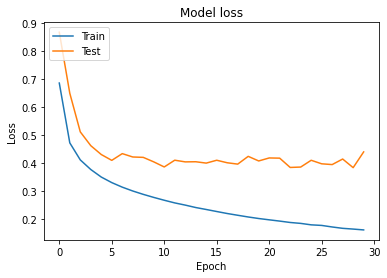

-----------------Test-----------------
Tasa de aciertos en test: 86.35 %
Tasa de errores en test: 13.65 %
Coeficiente de Kappa: 84.83 %


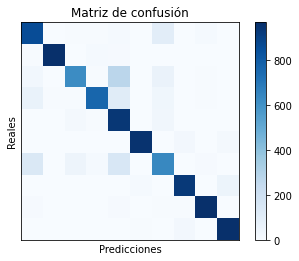

In [9]:
## PRIMER MODELO. 
# Capa de entrada: 784 neuronas
# Capa oculta: ReLU de 256 neuronas
# Capa de salida: softmax de 10 neuronas.
num_classes = train_labels.shape[1]
model1 = Sequential()
model1.add(Dense(256, activation='relu', input_shape=(28*28,), kernel_regularizer=l2(0.00001)))
model1.add(Dense(num_classes, activation='softmax'))
# Compilamos el modelo multiclase
model1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
trained_model = train_model(model1, train_images, train_labels, 0.3, 256, num_classes, 30)
plot_train(trained_model)
eval_model(model1, test_images, test_labels, eval_cnn=False)

Como podemos apreciar hemos conseguido una buena **precisión** de aproximadamente el **86%**, lo que nos indica que este modelo sencillo ha sido capaz de clasificar adecuadamente la mayoría de las imágenes. Observando la matriz de confusión podemos observar que los cuadrados más oscuros se corresponden con una mayor tasa de aciertos, y al encontrarse en diagonal, nos indican que la mayoría de las muestras han sido correctamente clasificadas. El resto de los cuadrados de color más claro se corresponden con las prendas de ropa mal clasificadas, que como podemos observar, son mínimas. 

En cuanto a la evolución del aprendizaje podemos observar que la curva del conjunto de entrenamiento es descendente, mientras que la de validación es muy irregular, llegando a ser ascedente a partir de la época 15. Esto nos indica que la última parte del entrenamiento no ha sido beneficiosa para el modelo y ha perdido capacidad de generalización, aumentando la tasa de fallos.

Por último, disponemos de un **coeficiente de Kappa de 85%**, lo que significa que el modelo está utilizando lo aprendido para clasificar las muestras desconocidas, y que difiere mucho de los resultados que proporcionaría un clasificador aleatorio. Por lo tanto, podemos determinar que con una topología de red sencilla podemos conseguir un modelo predictivo de buena calidad.

<a name="modelo2"></a>
## Modelo 2. Dropout

En este segundo modelo vamos a introducir un mayor número de capas ocultas además de una técnica denominada ***dropout***. Consiste en desactivar aleatoriamente un determinado porcentaje de neuronas de una capa con el objetivo de reducir el **sobreajuste**. Este fenómeno ocurre a menudo cuando existe una gran cantidad de neuronas en una capa que pueden verse influenciadas entre sí y, por lo tanto, aportan información similar con lo que el modelo no mejora. Por ello, esta técnica pretende reducir el número de neuronas que contribuyen al entrenamiento para que realicen un mayor esfuerzo por conseguir características que mejoren la clasificación.

Para ajustar el porcentaje de neuronas a desactivar, existen varios artículos [2] que comentan las tres opciones posibles. En primer lugar podemos establecer una capa *dropout* en la de entrada, también conocida como **capa visible**. Tras diversos experimentos, podemos determinar que tanto para **valores altos como bajos, los resultados empeoran**, tanto por la tasa de aciertos que se sitúa sobre un 83% como el coeficiente de Kappa que disminuye hasta el 81%. Por lo tanto, en nuestro modelo no vamos a introducir *dropout* en la capa de entrada.

Para las **capas ocultas** la tasa más adecuada suele estar en el rango [0.2, 0.5]. Según las diversas pruebas que hemos realizado, estableciendo el valor máximo en una capa es más ventajoso que en todas las capas, siendo la diferencia de 3 puntos en la tasa de acierto y el coeficiente de Kappa. Esto nos indica que **restringir demasiado el uso de las neuronas de las capas ocultas provoca cierta pérdida de información** que se traduce en una menor capacidad de generalización. Sin embargo, apostando por el valor mínimo de 0.2 en todas las capas ocultas, hemos conseguido mejorar la tasa de acierto hasta alcanza aproximadamente un 89% con un coeficiente de Kappa alrededor del 88%. 

Por otro lado, añadir más capas ocultas no siempre significa obtener un mejor modelo, ya que, de nuevo, puede producirse sobreajuste y perder capacidad de predicción. Para nuestro problema, tras realizar diversos experimentos, hemos concluido que **el modelo no mejora significativamente con un mayor número de capas ocultas**, sino que su comportamiento es muy similar al anterior de topología básica. De entre todos los experimentos, presentamos un segundo modelo compuesto por dos capas ocultas adicionales de 128 y 64 neuronas, respectivamente, más capas *dropout* solo para las tres ocultas con una tasa de 0.2, ya que es la mejores resultados nos ha proporcionado hasta el momento.

Finalmente, como en el caso anterior, **un mayor número de iteraciones no se traduce en mejores resultados**, por lo que continuamos estableciendo como número de épocas 30.


Tiempo de entrenamiento: 21.96 segundos.


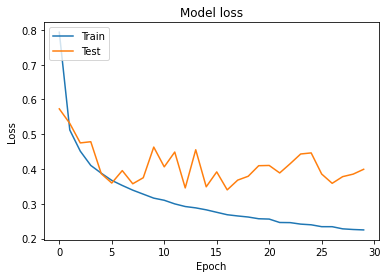

-----------------Test-----------------
Tasa de aciertos en test: 87.17 %
Tasa de errores en test: 12.83 %
Coeficiente de Kappa: 85.74 %


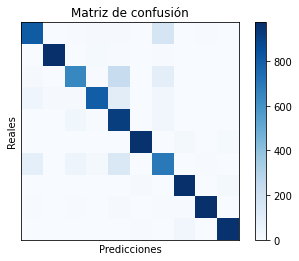

In [22]:
## SEGUNDO MODELO. 
# Capa de entrada: 784 neuronas
# Primera capa oculta: ReLU de 256 neuronas con dropout 0.2
# Segunda capa oculta: ReLU de 128 neuronas con dropout 0.2
# Tercera capa oculta: ReLU de 64 neuronas con dropout 0.2
# Capa de salida: softmax de 10 neuronas.
num_classes = train_labels.shape[1]
model2 = Sequential()
model2.add(Dense(256, activation='relu', input_shape=(28*28,)))
model2.add(Dropout(rate=0.2))
model2.add(Dense(128, activation='relu', kernel_regularizer=l2(0.00001)))
model2.add(Dropout(rate=0.2))
model2.add(Dense(64, activation='relu', kernel_regularizer=l2(0.00001)))
model2.add(Dropout(rate=0.2))
model2.add(Dense(num_classes, activation='softmax'))
# Compilamos el modelo multiclase
model2.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
trained_model2 = train_model(model2, train_images, train_labels, 0.3, 256, num_classes, 30)
plot_train(trained_model2)
eval_model(model2, test_images, test_labels, False)

Como podemos apreciar los resultados son muy similares a los del modelo anterior, mejorando ligeramente tanto en la tasa de aciertos (precisión) como en el coeficiente de *Kappa*, aunque no presentan mejoras significativas pese a la complejidad y el mayor tiempo de entrenamiento.

De igual modo, en la evolución del entrenamiento también dispone de una curva muy similar, mientras que en la de validación podemos observar más irregularidades que provocan picos más acusados que en el caso anterior, aunque es ligeramente más descendente, de ahí a que aporte mejores resultados en la tasa de aciertos. Esto nos indica que al añadir regularización *L2* más la técnica *dropout*, hemos ayudado a evitar el sobreaprendizaje que puediese occurrir con respecto a al conjunto de entrenamiento, por lo que consigue una clasificación ligeramente mejor. Sin embargo, una topología más compleja, como es el caso, provoca un comportamiento más irregular y un entrenamiento más inestable al depender de un mayor número de capas y neuronas involucradas. 

<a name="modelo3"></a>
## Modelo 3. Red convolutiva

En este tercer modelo vamos a entrenar una **red convolutiva** para comprobar si, con una topología orientada a imágenes, conseguimos mejorar los resultados que hemos obtenido hasta el momento. 

Al tratarse de una CNN, el preprocesamiento del conjunto de datos es ligeramente diferente al anterior. Mantenemos el escalado de los valores de las imágenes, pero debemos transformarlas en **vectores 3D** con la siguiente estructura: (alto, ancho, número de canales). Por ello, definimos un nuevo procesamiento que incluya esta última modificación para trabajar con un conjunto de datos compatible con este modelo de red.

Asimismo, también hemos realizado varios experimentos para conocer los distintos resultados que proporcionan los optimizadores de Keras. En este caso, **Adam** ha sido el que mejor calidad~tiempo obtiene, por lo que para los modelos convolotuvos será este el que utilicemos en lugar del RMSprop. La razón de ello reside en que este algoritmo es uno de los más eficientes computacionalmente y se encuentra orientado para aplicarlo en problemas con muchos datos por su robustez en los cambios del Gradiente Descendente que utiliza [3].

Como este proceso es común al uso de los posteriores modelos convolutivos, también hemos incluido la posibilidad de incluir la técnica de **aumentación de datos**, con la que generar imágenes modificadas con respecto al conjunto original. El objetivo consiste en evitar un sobreajuste a los datos de entrenamiento proporcionándole al modelo muestras de diferentes cualidades a las originales. Para ello realizaremos algunas transformaciones para cambiarlas ligeramente, de modo que al modelo le cueste más identificarlas. Esto se ha realizado utilizando la biblioteca *Augmentor*, la cual tras definir una serie de operaciones en un *Pipeline* genera un determinado número de imágenes teniendo como base las del conjunto de entrenamiento. Estas nuevas imágenes sufrirán dos transformaciones que serán una rotación hacia un lado u otro y una transformación de tipo zoom. A continuación se puede ver la implementación de dicha función.

In [6]:
# Instalamos la librería necesaria para el aumento de datos
!pip install Augmentor
import Augmentor as aug
from sklearn.utils import shuffle
import numpy as np
def elastic_augmentor(train_images, train_labels, number_images):
    # Creamos el Pipeline de Augmentor
    pipe = aug.Pipeline()
    # Introducimos la operación de distorsión aleatoria, esto nos proporciona una distorsión elástica leve
    pipe.random_distortion(probability = 0.5, grid_width = 5, grid_height = 5, magnitude = 1)
    # Introducimos la operación de rotación hacia ambos lados
    pipe.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    # Introducimos la operación de zoom con un zoom entre 1.1 y 1.3
    pipe.zoom(probability=0.3, min_factor=1.1, max_factor=1.3)
    # Definimos el generador de imágenes
    g = pipe.keras_generator_from_array(train_images, train_labels, batch_size=number_images)
    
    # Generamos tantas imágenes y etiquetas como hayamos especificado anteriormente
    X, y = next(g)
    # Le damos al array de imágenes obtenidas la misma forma que nuestro dataset original
    X = X.reshape((number_images, 28, 28))
    
    # Concatenamos imágenes y etiquetas generadas con los conjuntos originales y los desordenamos
    train_images = np.concatenate((train_images,X), axis=0)
    train_labels = np.concatenate((train_labels,y), axis=0)
    train_images, train_labels = shuffle(train_images, train_labels, random_state=1)
    return [train_images, train_labels]


In [0]:
def load_cnn_data(augmentation=False):
  """Función para preprocesar los dos conjuntos de datos para que sean aceptados
    por una CNN. Existe la posibilidad de aplicar la técnica augmentation para 
    fabricar más imágenes con ciertas transformaciones."""
  # Obtenemos los datos originales de nuevo
  (train_images_cnn, train_labels_cnn), (test_images_cnn, test_labels_cnn) = fashion_mnist.load_data()
  # Aplicamos la técnica augmentation si el argumento está a True
  if (augmentation):
    [train_images_cnn, train_labels_cnn] = elastic_augmentor(train_images_cnn, train_labels_cnn, 20000)
  # Escalamos los valores para normalizarlos en el rango [0,1] (train_images, train_labels), (test_images, test_labels)
  train_images_cnn = train_images_cnn.astype('float32') / 255.0
  test_images_cnn = test_images_cnn.astype('float32') / 255.0
  # Convertimos las imágenes en vectores 3D (alto, ancho, canales)
  dim = train_images_cnn.shape[1]
  num_classes = 10
  channels = 1
  train_images_cnn = np.reshape(train_images_cnn, (train_images_cnn.shape[0], dim, dim, channels))
  test_images_cnn = np.reshape(test_images_cnn, (test_images_cnn.shape[0], dim, dim, channels))

  print("Conjunto de datos de entrenamiento para la CNN:", train_images_cnn.shape)
  print("Conjunto de datos de test para la CNN:", test_images_cnn.shape)

  return [train_images_cnn, train_labels_cnn, test_images_cnn, test_labels_cnn]

En este primer modelo convolutivo, no vamos a aplicar la técnica de aumentación de datos, solo la transformación a vectores 3D. A continuación, hemos experimentado con diferentes topologías, desde las más sencillas con una única capa convolutiva, hasta las más complejas con varias convolutivas, *pooling* y normalización *batch*. Sin embargo, la que mejores resultados nos ha proporcionado es la que presentamos a continuación. Dispone de **dos capas convolutivas** ReLU de 32 y 64 neuronas, respectivamente, **una capa max pooling** de tamaño 2x2, **dos capas dropout** además de las restantes capas normales que las interconectan entre sí. Por último, hemos reducido el tamaño del lote de 256 a 128 para realizar un mayor número de actualizaciones de los pesos de las distintas capas y así obtener un modelo más preciso.

Sin embargo, la diferencia principal reside en la inclusión de la técnica *dropout* que es la que nos ha permitido superar el **92% de precisión y de coeficiente de Kappa**. Asimismo, si apreciamos la matriz de confusión podemos observar que la mayoría de los cuadrados diagonales, las muestras bien clasificadas, son de un tono más oscuro, lo que se traduce en un mayor número de prendas bien clasificadas por el modelo. Por lo tanto, podemos concluir que aplicar una red convolutiva más *dropout* mejora considerablemente los resultados de clasificación, puesto que utilizamos tecnología pensada para tratar con imágenes y además evitamos el sobreajuste gracias a la desactivación aleatoria de algunas neuronas de las últimas capas.

Conjunto de datos de entrenamiento para la CNN: (60000, 28, 28, 1)
Conjunto de datos de test para la CNN: (10000, 28, 28, 1)

Tiempo de entrenamiento: 118.29 segundos.


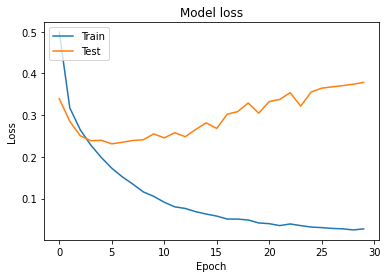

-----------------Test-----------------
Tasa de aciertos en test: 92.35 %
Tasa de errores en test: 7.65 %
Coeficiente de Kappa: 91.5 %


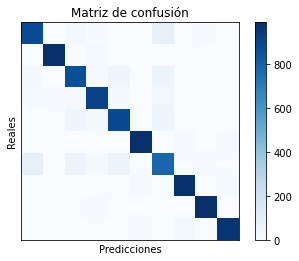

In [25]:
# Datos preprocesados para la CNN
cnn_data = load_cnn_data()
train_imgs_cnn = cnn_data[0]
train_labels_cnn = cnn_data[1]
test_imgs_cnn = cnn_data[2]
test_labels_cnn = cnn_data[3]
dim = train_imgs_cnn.shape[1]
num_classes = 10
channels = 1

## TERCER MODELO.
# Capa convolutiva ReLU de 32 neuronas
# Capa convolutiva ReLU de 64 neuronas
# Capa max pooling de 2x2
# Capa dropout de 0.25
# Capa Flatten para suavizar las entradas
# Capa normal ReLU de 128 neuronas
# Capa dropout de 0.2
# Capa de salida de 10 neuronas
model3 = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(dim, dim, channels)),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])
# Compilamos el modelo
model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Entrenamos el modelo
trained_model3 = train_model(model3, train_imgs_cnn, train_labels_cnn, 0.3, 128, 10, 30)
# Graficamos la evolución del entrenamiento
plot_train(trained_model3)
eval_model(model3, test_imgs_cnn, test_labels_cnn, True)

<a name="modelo4"></a>
## Modelo 4. Data augmentation

En este cuarto modelo, sí **vamos a aplicar la técnica de aumentación de datos** explicada anteriormente para intentar mejorar los resultados proporcionados hasta ahora. Para ello vamos a replicar la misma topología anterior solo que, en lugar de entrenar con el conjunto original, lo vamos a sustituir por el conjunto de imágenes aumentado. Por lo tanto, reutilizamos el modelo compilado anteriormente. 

Hemos variado algunos parámetros de entrenamiento, como el número máximo de iteraciones y el tamaño del lote. En el primer caso hemos duplicado el número de ejecuciones de 30 a 60, ya que disponemos de un mayor número de muestras y por tanto el modelo puede necesitar más tiempo para converger. Sin embargo, los resultados proporcionados son algo peores.
Al aumentar el número de muestras, también podemos aumentar el tamaño del lote, estableciéndolo también al doble del actual (256). No obstante, de nuevo, tanto la precisión como el coeficiente de *Kappa* son levemente inferiores y, por tanto, en base a estos resultados, también mantendremos los mismos valores de entrenamiento que en el modelo anterior.


Conjunto de datos de entrenamiento para la CNN: (80000, 28, 28, 1)
Conjunto de datos de test para la CNN: (10000, 28, 28, 1)

Tiempo de entrenamiento: 156.51 segundos.


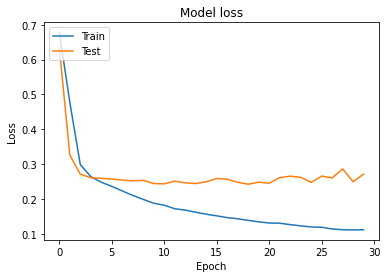

-----------------Test-----------------
Tasa de aciertos en test: 92.57 %
Tasa de errores en test: 7.43 %
Coeficiente de Kappa: 91.74 %


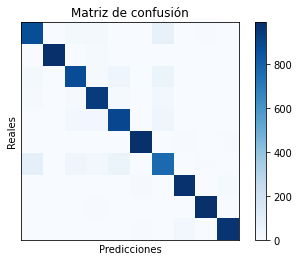

In [26]:
# Obtenemos los conjuntos de datos, aumentando el de entrenamiento
aug_data = load_cnn_data(True)
trainimgs_aug = aug_data[0]
trainlab_aug = aug_data[1]
testimgs_aug = aug_data[2]
testlab_aug = aug_data[3]
# Hacemos una copia del modelo anterior
model4 = model3
# Entrenamos el modelo
trained_model4 = train_model(model4, trainimgs_aug, trainlab_aug, 0.3, 128, 10, 30)
# Graficamos la evolución del entrenamiento
plot_train(trained_model4)
# Validamos el nuevo modelo
eval_model(model4, testimgs_aug, testlab_aug, True)

Como podemos apreciar, con un conjunto de entrenamiento más amplio y diverso de imágenes, hemos conseguido, aproximadamente, un **coeficiente de Kappa y precisión por encima del 92%**. Estos valores son muy similares a los del anterior modelo entrenado solamente con el conjunto original. Sin embargo, la curva de aprendizaje del conjunto de validación es distinta. En esta podemos observar que se trata de una función descedente hasta la época 15 aproximadamente, en la que cambia de sentido ligeramente. Mientras que en el modelo anterior, comenzaba a ascender sobre la iteración quinta de forma casi exponencial. 

Esto nos indica que transformar los datos de entrenamiento nos ayuda a eliminar el posible sobreajuste del modelo, pero para nuestro problema y esta topología concreta, no nos ayuda a mejorar su precisión o su coeficiente de Kappa de forma significativa.

<a name="modelo5"></a>
## Modelo 5. Entrenamiento combinado

En este quinto modelo, vamos a aplicar una combinación entre el entrenamiento con el conjunto de imágenes original y el conjunto de datos sintético que obtenemos con *data augmentation*. Esta idea la hemos obtenido de esta fuente [4] en la que, utilizando una red convolutiva, realiza un primer entrenamiento con el conjunto original de 10 épocas, y a continuación realiza el mismo procedimiento pero utilizando las imágenes transformadas por algún tiempo más (unas 50 iteraciones). 

El objetivo reside en dar a conocer los datos originales, en primera instancia, sin realizar demasiadas iteraciones para evitar que el modelo comience a sobreajustarse. En este momento, le presentamos las mismas imágenes transformadas para dificultar su entrenamiento y así conseguir que sea más robusto. En este caso, **la topología de la red será la misma que presentamos en el tercer y cuarto modelo**, por lo que la reutilizaremos.

Conjunto de datos de entrenamiento para la CNN: (60000, 28, 28, 1)
Conjunto de datos de test para la CNN: (10000, 28, 28, 1)

Tiempo de entrenamiento: 39.38 segundos.


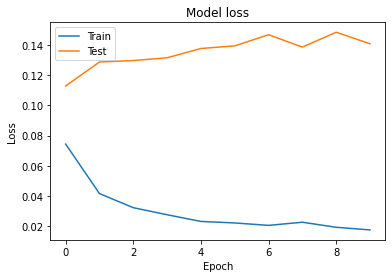

-----------------Test-----------------
Tasa de aciertos en test: 92.78 %
Tasa de errores en test: 7.22 %
Coeficiente de Kappa: 91.98 %


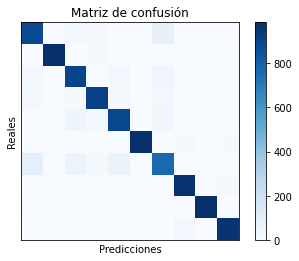

In [28]:
# Hacemos una copia de la mejor topología de CNN encontrada hasta el momento
model5 = model3 

# Obtenemos los datos originales para realizar un primer entrenamiento
cnn_data = load_cnn_data()
train_imgs_cnn = cnn_data[0]
train_labels_cnn = cnn_data[1]
test_imgs_cnn = cnn_data[2]
test_labels_cnn = cnn_data[3]

# Entrenamos el modelo con los datos originales
trained_model5 = train_model(model5, train_imgs_cnn, train_labels_cnn, 0.3, 128, 10, 10)
# Graficamos la evolución del entrenamiento
plot_train(trained_model5)
# Validamos el modelo con el conjunto de test
eval_model(model5, test_imgs_cnn, test_labels_cnn, True)

Conjunto de datos de entrenamiento para la CNN: (80000, 28, 28, 1)
Conjunto de datos de test para la CNN: (10000, 28, 28, 1)

Tiempo de entrenamiento: 261.2 segundos.


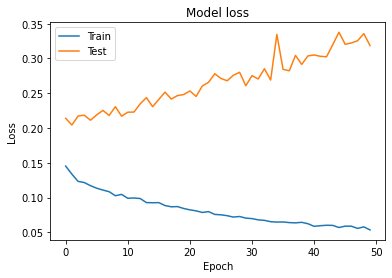

-----------------Test-----------------
Tasa de aciertos en test: 92.72 %
Tasa de errores en test: 7.28 %
Coeficiente de Kappa: 91.91 %


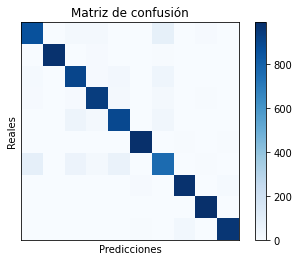

In [29]:
# Obtenemos el conjunto de entrenamiento aumentado
aug_data = load_cnn_data(True)
trainimgs_aug = aug_data[0]
trainlab_aug = aug_data[1]
testimgs_aug = aug_data[2]
testlab_aug = aug_data[3]

# Entrenamos el modelo
trained_model5 = train_model(model5, trainimgs_aug, trainlab_aug, 0.3, 128, 10, 50)
# Graficamos la evolución del entrenamiento
plot_train(trained_model5)
# Validamos el modelo con el conjunto de test
eval_model(model5, testimgs_aug, testlab_aug, True)

Como podemos apreciar, en el primer entrenamiento con las imágenes originales y durante 10 épocas, hemos obtenido un 92% de precisión y 91% de *Kappa*. Por lo tanto, podemos determinar que pese al poco tiempo, hemos conseguido unos buenos resultados con esta topología.

Mientras que con el segundo entrenamiento durante 50 iteraciones con el conjunto de entrenamiento aumentado hemos obtenido unos **resultados muy similares aunque algo mejores**. Sin embargo, en total, el tiempo invertido en entrenar este modelo es mucho mayor que el del tercer y cuarto modelo puesto que el último entrenamiento dispone de un mayor número de muestras y de iteraciones. Asimismo, si observamos ambas gráficas de las evoluciones de ambos entrenamientos podemos apreciar que aunque la curva del conjunto de entrenamiento es descendente, la del conjunto de validación tiende al alza. Lo que nos indica que ambos entrenamientos la red neuronal no ha conseguido suficiente información como para clasificar mejor las muestras de validación. 

Por lo tanto, en base a los resultados obtenidos, podemos determinar que los dos entrenamientos combinados, **para nuestra topología, no merecen la pena** puesto que el tiempo de entrenamiento es mucho mayor para unos resultados nada significativos con respecto a los que ya teníamos.

<a name="modelo6"></a>
## Modelo 6. Transfer learning

Como hemos podido apreciar, las mejoras conseguidas hasta el momento no han sido demasiado significantes como podríamos esperar. Esto puede ser debido a que la red no aprenda las características de las imágenes lo suficientemente bien por lo que continua cometiendo errores.  
 
Una posibles solución a este problema se conoce como **Transfer Learning**. Esta técnica es de gran relevancia en el *Deep learning* y es que en lugar de entrenar una red neuronal desde cero, lo cual puede necesitar una gran cantidad de datos y  tiempo, utilizamos un modelo ya entrenado. De este modo, podemos obtener una red pre-entrenada como punto de partida, para posteriormente, continuar entrenándola con nuestro conjunto de datos.
 
El principal objetivo reside en utilizar el conocimiento aprendido por la red neuronal para reconocer más fácilmente los patrones de nuestros datos y ayudar así en la clasificación de las imágenes.

Para este proposito podemos utilizar una gran variedad de redes, y es que en Keras existen diversos modelos pre-entrenados para Visión por Computador [5]. De todos los existentes, vamos a aplicar el **VGG16** inspirándonos en este tutorial [6] para conocer las condiciones y el preprocesamiento que se le debe realizar al conjunto para utilizar este modelo. 

En primer lugar, vamos a definir una función comun tanto a este modelo como al siguiente en la que se transformen transformar las imágenes del conjunto de en vectores 3D y escalarlas hasta los 48x48 píxeles puesto que es el formato de entrada que acepta la red VGG16. A continuación, normalizamos los valores como en los modelos anteriores, y los preprocesamos para codificarlos como un conjunto de imágenes [7]. Por último, convertimos las etiquetas en multidimensionales para que cada fila esté representada por diez elementos en los que todos son 0 excepto un 1 en la casilla a la etiqueta que corresponde la imagen. Este mismo procedimiento se puede realizar sobre el conjunto aumentado de imágenes aplicando, para ello, la función explicada anteriormente con la que realizar *data augmentation*.


In [0]:
def load_data_vgg16(augmentation):
  # Obtenemos los conjuntos originales y unificamos los píxeles en un solo vector 
  # de 784 componentes
  (train_X, train_Y), (test_X, test_Y) = fashion_mnist.load_data()
  if (augmentation > 0):
    (train_X, train_Y) = elastic_augmentor(train_X, train_Y, 50000)

  train_X = train_X.reshape((train_X.shape[0], 28*28))
  test_X = test_X.reshape((test_X.shape[0], 28*28))  
  # Transformamos los vectores a 3D
  train_X = np.dstack([train_X] * 3)
  test_X = np.dstack([test_X] * 3)
  # Volvemos desplegar los píxeles en 3D
  train_X = train_X.reshape(-1, 28, 28, 3)
  test_X = test_X.reshape (-1, 28, 28, 3)
  # Reescalamos las imágenes a 48x48 para que las acepte VGG16
  train_X = np.asarray([img_to_array(
      array_to_img(im, scale=False).resize((48,48))) for im in train_X])
  test_X = np.asarray([img_to_array
      (array_to_img(im, scale=False).resize((48,48))) for im in test_X])
  print("Conjunto de entrenamiento preprocesado:", train_X.shape)
  print("Conjunto de test preprocesado:", test_X.shape)

  # Normalizamos los datos a un rango [0,1]
  train_X = train_X / 255.
  test_X = test_X / 255.
  train_X = train_X.astype('float32')
  test_X = test_X.astype('float32')
  # Preprocesamos los dos conjuntos 
  train_X = preprocess_input(train_X)
  test_X = preprocess_input(test_X)

  # Transformamos las etiquetas a binarias (one-hot encoding)
  train_Y_one_hot = to_categorical(train_Y)
  test_Y_one_hot = to_categorical(test_Y)
  print("Etiquetas de entrenamiento preprocesadas:", train_Y_one_hot.shape)
  print("Etiquetas de test preprocesadas:", test_Y_one_hot.shape, "\n")

  return [train_X, train_Y_one_hot, test_X, test_Y_one_hot]

A continuación cargamos el modelo VGG16 con los parámetros explicados en los comentarios. Como podemos observar en el resumen de su topología, se trata de una **red convolutiva** bastante compleja con dos capas convolutivas y una de *max pooling* al comienzo, ampliándolas a tres convolutivas al final de la red. Del mismo modo ocurre con el número de neuronas, que comienzan siendo 64 en las primeras capas hasta llegar a 512 en las últimas. Parece ser que la arquitectura de esta red está pensada para realizar, primeramente, un reconocimiento de los datos, con pocas capas convolutivas y un menor número de neuronas. Mientras que, conforme avanza el entrenamiento, se introducen un mayor número de neuronas y convolutivas para intentar extraer los detalles de las imágenes. Es un tipo de entrenamiento progresivo en el que se aumenta la complejidad de la red conforme más avanzamos por su topología.

In [9]:
# Obtenemos los datos transformados sin aplicar la técnica de aumentación
data_vgg16 = load_data_vgg16(0)
train_X = data_vgg16[0]
train_Y = data_vgg16[1]
test_X = data_vgg16[2]
test_Y = data_vgg16[3]

# Construimos el modelo base de VGG16
## Los pesos los inicializamos a partir de los obtenidos en un pre-entrenamiento
## sobre el conjunto de datos ImageNET.
## No incluimos las tres primeras capas conectadas al comienzo de la red.
## Por último especificamos la estructura de las imágenes (48x48, 3)
img_width_vgg16 = 48
img_height_vgg16 = 48
img_channels_vgg16 = 3
vgg16 = VGG16(weights='imagenet', include_top=False, 
  input_shape=(img_width_vgg16, img_height_vgg16, img_channels_vgg16))
vgg16.summary()

Conjunto de entrenamiento preprocesado: (60000, 48, 48, 3)
Conjunto de test preprocesado: (10000, 48, 48, 3)
Etiquetas de entrenamiento preprocesadas: (60000, 10)
Etiquetas de test preprocesadas: (10000, 10) 

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________

Por último, extraemos las características de los dos conjuntos de datos y las procesamos para que puedan ser proporcionadas a nuestro modelo. Tras varios experimentos variando los parámetros y las capas de la red, la que mejores resultados nos ha proporcionado consta de una **capa ReLU** de 512 neuronas, una **capa LeakyReLU** y la tradicional última de salida para este problema con 10 neuronas. Como función de optimización, pese a no ser una red convolutiva, ha sido el algoritmo *Adam* el que ha proporcionado una tasa de aciertos y un coeficiente de *Kappa* mayor que el RMSProp, con una diferencia de hasta un 3%.

Durante el entrenamiento, además, hemos comprobado que incluir las técnicas ***reduce learning*** y ***early stopping*** son beneficiosas para nuestro modelo. En el primer caso, este método tiene como objetivo disminuir progresivamente la tasa de aprendizaje si detecta que la red no mejora [8]. Mientras que la segunda técnica finaliza el entrenamiento si la medida escogida, que en nuestro caso es el error, no continua minimizándose [9]. 

Asimismo, destacamos que no hemos podido utilizar las funciones de entrenamiento y validación porque en este modelo existen ciertos requisitos sobre el formato de los datos que le debemos proporcionar para obtener las medidas. Un ejemplo de esto lo podemos observar en el formato de las etiquetas del conjunto de test para calcular la precisión y la tasa de fallos, el cual se corresponde con el muntidimensional o *one-hot encoding*. Mientras que para calcular el coeficiente de *Kappa* debemos suministrarle un vector sencillo de etiquetas.

10000/10000 [==============================] - 10s 1ms/step


/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '



Tiempo de entrenamiento: 1161.69 segundos.


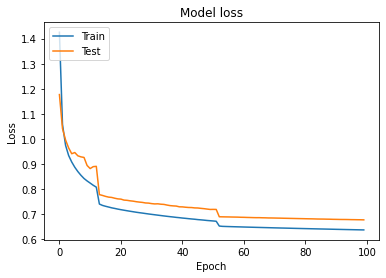

-----------------Test-----------------
Tasa de aciertos en test: 75.82 %
Tasa de errores en test: 24.18 %
Coeficiente de Kappa: 73.13 %


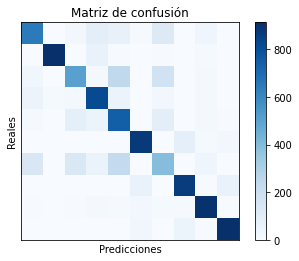

In [11]:
# Extraemos las características de los dos conjuntos estableciendo un
# lote de tamaño 16
batch_size_vgg16 = 16
train_features = vgg16.predict(np.array(train_X), batch_size=batch_size_vgg16, verbose=1)
test_features = vgg16.predict(np.array(test_X), batch_size=batch_size_vgg16, verbose=1)
# Preprocesamos las características para proporcionárselas a la red
train_features_flat = np.reshape(train_features, (train_features.shape[0], 1*1*512))
test_features_flat = np.reshape(test_features, (test_features.shape[0], 1*1*512))

# SEXTO MODELO
## Una capa de entrada ReLU con 512 neuronas
## Una capa oculta Leaky ReLU
## Una capa de salida softmax con 10 neuronas
model6 = models.Sequential()
model6.add(layers.Dense(512, activation='relu', input_dim=(1*1*512)))
model6.add(layers.LeakyReLU(alpha=0.1))
model6.add(layers.Dense(10, activation='softmax'))
# Compilamos el modelo 
model6.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

# Definimos dos callbacks para el entrenamiento
## Reduce learning: técnica para reducir la tasa de aprendizaje si el modelo no mejora
reduce_learning = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
    patience=2, verbose=0, mode='auto', epsilon=0.0001, cooldown=2, min_lr=0)
## Early stopping: termina el entrenamiento cuando no disminuya el error
early_stopping = callbacks.EarlyStopping(monitor='val_loss', min_delta=0,
    patience=7, verbose=0, mode='auto')
callbacks = [reduce_learning, early_stopping]
# Entrenamos el modelo con los parámetros establecidos anteriormente
trained_model6 = train_model(model6, train_features_flat, train_Y, 0.3, batch_size_vgg16, 10, 100, callbacks)
# Graficamos la evolución del modelo
plot_train(trained_model6)
# Validamos el modelo con el conjunto de test
eval_model(model6, test_features_flat, test_Y, False)

Como podemos apreciar, el modelo resultante dispone de una menor capacidad de generalización que los anteriores, pese a tener como aliado una de las redes neuronales más potentes. Sin embargo, para nuestro problema solo es capaz de proporcionar alrededor de un **75% de precisión y 73% de coeficiente de Kappa**. Este empeoramiento también se ve reflejado en la matriz de confusión, en la que podemos apreciar un mayor número de cuadrados, en la diagonal, con un color más claro que el que venimos observando con los modelos anteriores. Lo que nos indica, que hay un mayor número de muestras mal clasificadas, especialmente en los casos de la tercera, quinta y séptima prenda (*Dress*, *Sandal*, *Sneaker*). 

En relación al progreso del entrenamiento podemos observar en la gráfica, que en el caso del conjunto de entrenamiento es una curva descendente, mientras que en el conjunto de validación al comienzo podemos observar ciertos picos que desaparecen hacia la mitad del proceso. Esto nos sugiere que al comienzo del entrenamiento el modelo ha presentado ciertas dificultades para ajustar los parámetros para mejorar su clasificación. Asimismo, hacia la época 20 podemos observar que la evolución se estanca y el modelo no mejora apenas nada hasta la época 60, en la que el *early stopping* decide finalizarlo. Por lo que podemos deducir que en más de la mitad del entrenamiento apenas el modelo consigue información para continuar su aprendizaje. 

Por último, hemos intentado combinar esta técnica con ***data augmentation*** los resultados han sido similares. Por lo tanto, aumentar el conjunto de entrenamiento incluyendo muestras diferentes no ha ayudado a que este modelo mejore su capacidad de predicción, por lo que no lo incluimos como experimento ya que su entrenamiento es aún más costoso computacionalmente.

En base a los resultados podemos determinar que no por disponer de un modelo más complejo, e incluso de una red neuronal popularmente conocida por resolver ciertos problemas con un buen rendimiento, nos asegura el poder obtener un modelo mejor para el problema *MNIST Fashion*.

<a name="modelo7"></a>
## Modelo 7. Fine Tuning

Por último vamos a utilizar otra técnica denominada ***fine tuning*** que consiste en hacer uso de una red neuronal pre-entrenada con el fin de poder adaptarla a nuestro problema. Para ello se suelen añadir algunas capas al modelo para entrenarlas con nuestro conjunto de imágenes, dejando las capas originales fuera de este segundo entrenamiento. Así, aprovechamos el conocimiento adquirido por esta red pre-entrenada para añadirle el asociado a nuestros datos con el que poder utilizarla para resolver este problema de clasificación. 

En nuestro caso, usaremos de nuevo el modelo **VGG16** anterior al que le añadiremos una capa ***GlobalAveragePooling***, que calcula el valor medio de cada característica identificada de la capa anterior para reducir los datos disponibles y preparar el modelo para obtener los resultados de clasificación [10]. Como segunda capa añadimos una **capa densa de 512** neuronas con una función de activación *ReLU* combinada con *dropout*. Por último, añadimos otra **capa densa *softmax*** con 10 neuronas para obtener las probabilidades de que una imagen se corresponda con las diferentes prendas disponibles. Tras experimentar con varias topologías, nos hemos inspirado en este tutorial [11] para presentar la arquitectura anterior, que es la que mejores resultados nos ha proporcionado.

En este caso, **tampoco es ventajoso aplicar** ***data augmentation*** principalmente por el coste computacional, temporal y de memoria. Uno de los inconvenientes de utilizar entornos *cloud* con recursos compartidos y limitados, es que tienes que adaptarte a ellos, salvo que desees invertir tu capital en conseguir más recursos. Tras realizar varios experimentos fallidos tanto por falta de memoria RAM como por los propios resultados, podemos determinar que no merece la pena aumentar el conjunto de datos, por lo que aplicaremos *fine tuning* al conjunto original.



In [15]:
# Obtenemos los datos transformados y aumentados
data_vgg16 = load_data_vgg16(0)
train_X = data_vgg16[0]
train_Y = data_vgg16[1]
test_X = data_vgg16[2]
test_Y = data_vgg16[3]

# Construimos el modelo base de VGG16
## Los pesos los inicializamos a partir de los obtenidos en un pre-entrenamiento
## sobre el conjunto de datos ImageNET.
## No incluimos las tres primeras capas conectadas al comienzo de la red.
## Por último especificamos la estructura de las imágenes (48x48, 3)
img_width_vgg16 = 48
img_height_vgg16 = 48
img_channels_vgg16 = 3
vgg16 = VGG16(weights='imagenet', include_top=False, 
  input_shape=(img_width_vgg16, img_height_vgg16, img_channels_vgg16))

# Obtenemos la arquitectura original de la red VGG16
x = vgg16.output
# Añadimos una primera capa GlobalAveragePooling
x = GlobalAveragePooling2D()(x)
# Añadimos una segunda capa ReLU de 512 neuronas completamente conectada
x = Dense(512, activation='relu')(x)
# Integramos la técnica dropout en esta capa
x = Dropout(0.3)(x)
# Añadimos la capa de salida softmax
predictions = Dense(10, activation='softmax')(x)
# Creamos el nuevo modelo modificado
model7 = Model(inputs=vgg16.input, outputs=predictions)

Conjunto de entrenamiento preprocesado: (60000, 48, 48, 3)
Conjunto de test preprocesado: (10000, 48, 48, 3)
Etiquetas de entrenamiento preprocesadas: (60000, 10)
Etiquetas de test preprocesadas: (10000, 10) 



Una vez disponemos del nuevo modelo VGG16, lo compilamos y actualizamos los pesos de las diferentes capas a nuestro conjunto de datos de entrenamiento. A continuación especificamos qué capas se van a re-entrenar con las imágenes de Fashion MNIST, que como hemos comentado anteriormente, lo recomendable es solamente repetir el proceso en las nuevas capas añadidas a la topología de la VGG16 para mantener su capacidad de extracción de características que nos ayude en el proceso de clasificación. Por último lanzamos el entrenamiento durante 50 épocas, con un lote de tamaño 256, un proceso de validación con un 30% del conjunto de datos de entrenamiento, graficamos la evolución de su entrenamiento y calculamos las medidas de calidad para evaluar el modelo obtenido. 

Como podemos observar los **resultados son mejores que en el caso anterior** debido a la posibilidad de añadir nuevas capas al modelo base para poder entrenarlas y adaptarlas a nuestros datos. Asimismo, hemos conseguido una mayor precisión y coeficiente de *Kappa* con la mitad de iteraciones, por lo que es un signo más de la potencia que se esconde tras la adaptación de un modelo existente al problema que deseamos resolver, en lugar de utilizarlo solamente para extraer las características de las imágenes. La parte negativa se encuentra en el tiempo puesto que este se dispara con respecto a todos los modelos anteriores. Sin embargo, es un aspecto que se puede cambiar añadiendo un mayor número de recursos para agilizar el proceso.


Tiempo de entrenamiento: 1518.82 segundos.


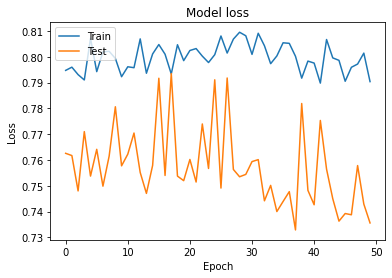

-----------------Test-----------------
Tasa de aciertos en test: 73.17 %
Tasa de errores en test: 26.83 %
Coeficiente de Kappa: 70.19 %


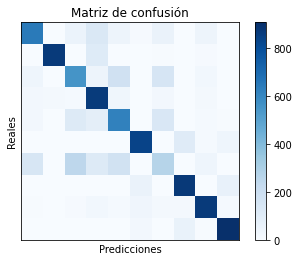

In [19]:
# Congelamos todas las capas del modelo VGG16 para que no sean re-entrenadas
for layer in vgg16.layers:
    layer.trainable = False
# Compilamos el nuevo modelo modificado
model7.compile(optimizer='adam', loss='categorical_crossentropy')
# Actualizamos los pesos de las capas con nuestros datos
model7.fit(train_X, train_Y, verbose=0)
# Las capas originales (18 primeras) las "congelamos" para que no re-entrenarlas.
for layer in model7.layers[:18]:
    layer.trainable = False
# Las nuevas capas añadidas son las que entrenaremos con nuestros datos.
for layer in model7.layers[18:]:
    layer.trainable = True
# Compilamos de nuevo el modelo con las capas a entrenar
model7.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Entrenamos el modelo
start_time = time.time()
trained_model7 = model7.fit(train_X, train_Y, batch_size=256, epochs=50, shuffle=True, validation_split=0.3, verbose=0)
elapsed_time = time.time() - start_time
print("\nTiempo de entrenamiento:", round(elapsed_time, 2), "segundos.")
# Graficamos el proceso de entrenamiento
plot_train(trained_model7)
# Validamos el modelo con el conjunto de test
eval_model(model7, test_X, test_Y, False)

<a name="conclusiones"></a>
## Conclusiones

Como hemos visto, hay una gran variedad de opciones que podemos utilizar a la hora de resolver un problema de clasificación. Obviamente, algunas de estas soluciones serán mejores que otras, y es que en la mayor parte de las ocasiones, no hay una solución clara a un problema. Por lo tanto, deberemos emplear una aproximación parecida a la que hemos realizado en este trabajo para encontrar la solución óptima. 
 
Nosotros hemos conseguido algunos resultados bastante interesantes y es que desde el modelo inicial hemos mejorado bastante los resultados obtenidos, los cuales los hemos recopilado en la siguiente tabla.
 
| Modelo | *Accuracy* | Coef. de Kappa | Tiempo |
| -- | -- | -- | -- |
| Básico | 86,35% | 84,83% | 26,18 s. | 
| Dropout | 87,17% | 85,14% | 21,96 s. |
| Red convolutiva | 92,35% | 91,5% | 118,29 s. |
| Data augmentation | 92,57% | 91,74% | 156,51 s.|
| CNN + Data augmentation | 92,72% | 91,91% | 261,2 s. |
| Transfer learning | 75,82% | 73,13% | 1.161,69 s. |
| Fine Tuning | 73,17% | 70,19% | 1.518,82 s. |
 
Como se puede observar, salvo por los últimos modelos se ha conseguido alcanzar un porcentaje de acierto bastante aceptable. De estos resultados podemos extraer las siguientes conclusiones. 

* En primer lugar, destacamos que con un modelo muy básico podemos obtener resultados bastante aceptables, tanto por la tasa de aciertos como por la calidad que demuestra el coeficiente de *Kappa*. Esto nos demuestra la potencia de las redes neuronales y su idoneidad para aplicarlas sobre problemas de clasificación. Asimismo, una de sus principales características es la cantidad de parámetros configurables de los que disponen, que te permiten ajustar el modelo a las necesidades de tu problema, como ha sido el caso de la **regularización**, con la que hemos obtenido un entrenamiento más estable y de mayor calidad. 

* Un segundo factor que hemos aprendido con respecto a la topología de la red es que, no por un mayor número de capas y/o neuronas, vamos a obtener un modelo con mayor capacidad de generalización, ya que pueden influir diversos factores como el sobreajuste a los datos de entrenamiento. Para nuestro problema, como hemos podido observar, no es nada recomendable aplicar una arquitectura compleja puesto que proporciona resultados muy similares a la básica comentada anteriormente, pero con una mayor inversión temporal y computacional.

* Por otro lado, es importante señalar la mejora conseguida aplicando **redes convolutivas** a nuestro problema puesto que, tratándose del análisis y clasificación de imágenes, es uno de los modelos que mejores resultados ha proporcionado a lo largo de su evolución gracias a su especialización en este campo, como anteriormente hemos comentado. 

* Otra de las técnicas aplicadas para reducir el problema del sobreaprendizaje, comentado anteriormente, consistía en **transformar y aumentar** el número de imágenes para generar muestras diferentes. El objetivo consistía en independizar al clasificador de las características de las imágenes para que pudiese predecir a qué prenda pertenece. Como hemos podido observar, en los modelos convolutivos ha sido ventajoso y posible aplicarlo puesto que no son topologías muy complejas y los resultados han sido ligeramente mejores. De hecho, el método combinado entre un entrenamiento tradicional y otro con el conjunto aumentado durante más iteraciones ha sido el que **mejores resultados** ha proporcionado, aunque a expensas de un cierto sacrificio en términos de tiempo de entrenamiento.  

* Por último destacamos que el poder utilizar un **modelo pre-entrenado** es una forma muy sencilla de abordar un problema de clasificación, siempre que se le puedan añadir algunas capas y adaptarlas a nuestros datos. En caso contrario, como hemos podido observar, el modelo por muy bueno que sea, si el problema para el que ha sido entrenado difiere del que tenemos nosotros, no va a tener suficiente información como para realizar predicciones de forma adecuada. Asimismo, el tiempo de entrenamiento como podemos apreciar en la tabla resumen se dispara para estos dos modelos por lo que también es un factor a considerar a la hora de elegir un modelo pre-entrenado.

Como conclusión final, destacamos que para nuestro problema podemos aplicar topologías muy sencillas para inmediatamente conseguir un buen clasificador. Sin embargo, si deseamos mejorar la calidad y la precisión, es preciso utilizar arquitecturas más complejas, especialmente las convolutivas que se encuentran enfocadas a resolver problemas con imágenes, pero a costa de un aumento considerable en el tiempo de entrenamiento y validación. Es por ello por lo que para cada problema es necesario realizar un estudio de su complejidad además de ejecutar una gran variedad de experimentos para que, mediante ensayo-error, podamos ajustar los parámetros para obtener un modelo dotado de una buena  capacidad de generalización.



<a name="bibliografia"></a>
## Bibliografía

1. Documentación sobre el parámetro `shuffle`, https://keras.io/api/preprocessing/image/
2. Jason Brownlee, *Dropout Regularization in Deep Learning Models With Keras*, https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/
3. Documentación sobre *Adam*, https://keras.io/api/optimizers/adam/
4. khanhnamle1994, fashion-mnist, https://github.com/khanhnamle1994/fashion-mnist/blob/master/CNN-4Conv.ipynb
5. Keras Applications: Available models, https://keras.io/api/applications/
6. Kaggle, *Classify Fashion_Mnist with VGG16*, https://www.kaggle.com/anandad/classify-fashion-mnist-with-vgg16
7. Documentación sobre *preprocess_input*, https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet/preprocess_input
8. *ReduceLROnPlateau: Reduce learning rate when a metric has stopped improving*, https://rdrr.io/cran/kerasR/man/ReduceLROnPlateau.html#:~:text=Models%20often%20benefit%20from%20reducing,the%20learning%20rate%20is%20reduced.
9. Jason Brownlee, *Use Early Stopping to Halt the Training of Neural Networks At the Right Time*, https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/#:~:text=Early%20Stopping%20in%20Keras,via%20a%20callback%20called%20EarlyStopping.&text=Training%20will%20stop%20when%20the,can%20be%20set%20to%201.
10. *An introduction to Global Average Pooling in convolutional neural networks*, https://adventuresinmachinelearning.com/global-average-pooling-convolutional-neural-networks/#:~:text=Global%20Average%20Pooling,for%20the%20final%20classification%20layer.
11. Shuhei Kishi, *VGG16 Fine-tuning model*, http://marubon-ds.blogspot.com/2017/09/vgg16-fine-tuning-model.html